In [1]:
from xml.etree import ElementTree
import pandas as pd
import datetime

In [2]:
tree = ElementTree.parse('C:/Users/9/Downloads/экспорт/apple_health_export/экспорт.xml')
root = tree.getroot()
records = root.findall('Record')

In [3]:
records_dict = {'type': [],
                'unit': [],
                'creationDate': [],
                'startDate': [],
                'endDate': [],
                'value': []
               }

In [4]:
for record in records:
    for attribute in records_dict.keys():
        attribute_value = record.get(attribute)
        records_dict[attribute].append(attribute_value)

In [5]:
types_dict = {
    'HKCategoryTypeIdentifierMindfulSession': 'Mindful Session',
    'HKQuantityTypeIdentifierDistanceCycling': 'Cycling Distance',
    'HKQuantityTypeIdentifierDistanceSwimming': 'Swimming Distance',
    'HKQuantityTypeIdentifierDistanceWalkingRunning': 'Walking + Running Distance',
    'HKQuantityTypeIdentifierFlightsClimbed': 'Flights Climbed',
    'HKQuantityTypeIdentifierHeartRate': 'Heart Rate',
    'HKQuantityTypeIdentifierRestingHeartRate': 'Resting Heart Rate',
    'HKQuantityTypeIdentifierStepCount': 'Steps',
    'HKQuantityTypeIdentifierActiveEnergyBurned': 'Active Calories',
    'HKQuantityTypeIdentifierBasalEnergyBurned': 'Resting Calories',
    'HKQuantityTypeIdentifierWalkingHeartRateAverage': 'Walking Heart Rate Average'
}

In [6]:
def td_to_m(td):
    seconds = td.seconds + td.days * 24 * 60 * 60
    return seconds // 60

In [7]:
df = pd.DataFrame(records_dict)
df.columns = ['type', 'unit', 'date', 'start', 'end', 'value']
df = df[df['type'].isin(types_dict.keys())]
df['value'] = df['value'].astype(float)
df['date'] = df['date'].astype('datetime64')
df['date'] = df['date'].dt.date
df['start'] = df['start'].astype('datetime64')
df['end'] = df['end'].astype('datetime64')
df['unit'] = df['unit'].astype(str)

In [8]:
df_1 = df[df['unit'] == 'count/min']
df_1 = df_1.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                      'end':'max',
                                                                      'value':'mean'})

In [9]:
df_2 = df[df['type'] == 'HKCategoryTypeIdentifierMindfulSession']
df_2['value'] = df_2['end'] - df_2['start']
df_2['value'] = df_2['value'].map(td_to_m)
df_2 = df_2.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                     'end':'max',
                                                                     'value':'sum'})

<ipython-input-9-9aefcd8c8fa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['value'] = df_2['end'] - df_2['start']
<ipython-input-9-9aefcd8c8fa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['value'] = df_2['value'].map(td_to_m)


In [10]:
df_3 = df[(df['unit'] != 'count/min') & (df['type'] != 'HKCategoryTypeIdentifierMindfulSession')]
df_3 = df_3.groupby(by=['date', 'type', 'unit'], as_index=False).agg({'start':'min',
                                                                      'end':'max',
                                                                      'value':'sum'})

In [11]:
df = pd.concat([df_1, df_2, df_3])

In [12]:
df['date'] = df['date'].astype(str)
df['type'] = df['type'].apply(lambda x: types_dict[x])
dates = df['date'].unique()

In [13]:
result = {
    'date': [],
    'Steps': [],
    'Walking + Running Distance': [],
    'Swimming Distance': [],
    'Cycling Distance': [],
    'Resting Calories': [],
    'Active Calories': [],
    'Flights Climbed': [],
    'Heart Rate': [],
    'Resting Heart Rate': [],
    'Walking Heart Rate Average': [],
    'Mindful Session': []
}

In [14]:
for date in dates:
    part = df[df['date'] == date]
    result['date'].append(date)
    for key in result.keys():
        if key == 'date':
            continue
        else:
            field = 'value'
        try:
            result[key].append(part[part['type'] == key][field].values[0])
        except IndexError:
            result[key].append(None)

In [15]:
result_df = pd.DataFrame(result)

In [16]:
result_df = result_df.round(2)

In [17]:
result_df = result_df.sort_values(by='date')

In [18]:
data = result_df

In [19]:
heart = data.drop(['Resting Calories', 'Steps', 'Active Calories', 'Flights Climbed', 'Walking + Running Distance', 'Swimming Distance', 'Cycling Distance', 'Mindful Session'], axis = 1)

In [20]:
heart.head(10)

,date,Heart Rate,Resting Heart Rate,Walking Heart Rate Average
839,2018-04-21,NaN,NaN,NaN
840,2018-04-22,NaN,NaN,NaN
841,2018-04-23,NaN,NaN,NaN
842,2018-04-24,NaN,NaN,NaN
843,2018-04-25,NaN,NaN,NaN
844,2018-04-26,NaN,NaN,NaN
845,2018-04-27,NaN,NaN,NaN
846,2018-04-28,NaN,NaN,NaN
847,2018-04-29,NaN,NaN,NaN
848,2018-04-30,NaN,NaN,NaN


In [21]:
heart=heart.reset_index(drop=True)

In [22]:
heart.tail(10)

,date,Heart Rate,Resting Heart Rate,Walking Heart Rate Average
1060,2021-03-17,93.30,57.0,102.0
1061,2021-03-18,107.98,61.0,114.0
1062,2021-03-19,94.73,58.0,104.0
1063,2021-03-20,100.96,55.0,110.0
1064,2021-03-21,94.05,56.0,100.0
1065,2021-03-22,86.43,56.0,97.0
1066,2021-03-23,84.98,55.0,99.0
1067,2021-03-24,92.87,56.0,100.5
1068,2021-03-25,90.93,57.0,111.0
1069,2021-03-26,100.67,NaN,NaN


In [23]:
heart = heart.loc[231:]

In [24]:
heart.head(10)

,date,Heart Rate,Resting Heart Rate,Walking Heart Rate Average
231,2018-12-09,70.18,NaN,105.0
232,2018-12-10,75.69,62.0,87.0
233,2018-12-11,64.61,56.0,NaN
234,2018-12-12,70.25,55.0,100.0
235,2018-12-13,71.69,58.0,109.0
236,2018-12-14,79.13,59.0,NaN
237,2018-12-15,83.15,60.0,110.5
238,2018-12-16,108.22,72.0,NaN
239,2018-12-17,71.67,61.0,NaN
240,2018-12-18,69.96,58.0,112.0


In [25]:
heart=heart.reset_index(drop=True)

In [26]:
heart.isnull().sum()

date                            0
Heart Rate                      0
Resting Heart Rate             75
Walking Heart Rate Average    215
dtype: int64

In [27]:
heart.shape

(839, 4)

In [28]:
rest_rate = heart.drop(['Heart Rate', 'Walking Heart Rate Average'], axis=1)

In [29]:
rest_rate = rest_rate.fillna(method = 'bfill')

In [30]:
rest_rate.head(10)

,date,Resting Heart Rate
0,2018-12-09,62.0
1,2018-12-10,62.0
2,2018-12-11,56.0
3,2018-12-12,55.0
4,2018-12-13,58.0
5,2018-12-14,59.0
6,2018-12-15,60.0
7,2018-12-16,72.0
8,2018-12-17,61.0
9,2018-12-18,58.0


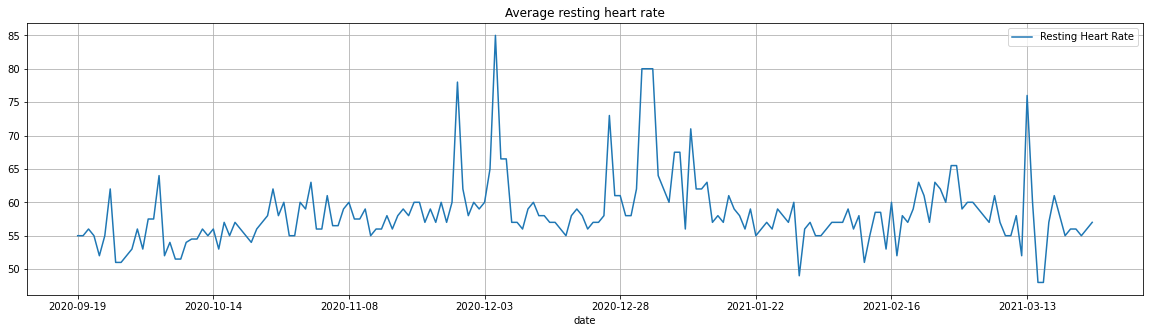

In [31]:
rest_rate.loc[650:].plot(x = 'date', y = 'Resting Heart Rate', 
               figsize = (20, 5), 
               title = 'Average resting heart rate', 
               grid = 'bool')